<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/NCAR-contemp-logo-blue.png"
     width="750px"
     alt="NCAR logo"
     style="vertical-align:middle;margin:30px 0px"/>

# Dask Arrays

**ESDS Dask Tutorial | 06 February, 2023**  

Negin Sobhani, Brian Vanderwende, Deepak Cherian, Ben Kirk  
Computational & Information Systems Lab (CISL)  
[negins@ucar.edu](mailto:negins@ucar.edu), [vanderwb@ucar.edu](mailto:vanderwb@ucar.edu)


---------

### In this tutorial, you learn:

* What is a Dask Array?
* Basic concepts and features of Dask Arrays
* Working with Dask arrays

**Related Dask Array Documentation**

* [Dask Array documentation](https://docs.dask.org/en/latest/array.html)
* [Dask Array API](https://docs.dask.org/en/latest/array-api.html)
* [Dask Array examples](https://examples.dask.org/array.html)


## Dask Arrays
Dask Arrays are basically parallelized version of NumPy arrays for processing *larger-than-memory data sets*. 

<img src="https://docs.dask.org/en/stable/_images/dask-array.svg" width="500px" style="horizontal-align:middle"/>

*Image credit: Anaconda, Inc. and contributors*

**Parallel**: Utilizes all available cores on your machine.

**Larger-than-memory**: Dask effectively reduces the memory footprint of large array computations by dividing the arrays into smaller pieces (called **chunks**) that can fit into memory and stream the data from disk.


**Blocked Algorithms:** Blocked algorithms split large computations into smaller computations which operate on subsets of the array.


**Dask Arrays are lazy:** Unlike Numpy, operations on Dask arrays are not computed until you explicitly request them. 

<div class="alert alert-block alert-info" markdown="1">

<b>Lazy Evaluation: objects are evaluated just in time when the results are needed!</b> 
</div>

Dask Arrays don't directly hold any data. Instead, they provide a symbolic representation of the necessary computations to generate the data. We will explain this more below.  

Lazy evaluation help us avoid having large pieces of memory resident on the workers and optimize the resource requirements.

Let's start exploring Dask Arrays:

-----------------

## Setup: Start a Dask Client
We will talk in-depth about Dask Cluster and Dask Clients later in this tutorial. Here we just created a local cluster and attached a client to it. 

In [1]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/workforce/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/workforce/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41581,Workers: 4
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/workforce/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:36314,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/workforce/proxy/33734/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:37518,


## Blocked Algorithms: 

Dask Arrays use blocked algorithms to organize large computations by performing smaller computations on smaller pieces (**chunks**) of data.


Let's see what this means in an example:

In [2]:
import numpy as np
import dask.array as da

# Let's make a simple numpy array
narr = np.array([
        [ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16]
        ])

# -- convert numpy array to dask array
darr = da.from_array( narr,chunks=(2, 2))

Now we can calculate the sum of this array using `darr.sum()` similar to numpy. **But how is it different from numpy?**


When we calculate the sum of darr, Dask assign each worker to perform a sum independently and combining the results at the end.


<img src="https://d33wubrfki0l68.cloudfront.net/f7bf6ca40c8f217386f83795b36e0c964c6a9d2b/ad6da/images/blog/what-is-dask-blockwise-sum.jpg" width="500px" />

*Image adapted from saturncloud.io*


## Task Graph

The Dask Task Graph serves as a **blueprint** for executing complex computations.  

The Task Graph defines the relationships between tasks, and the order in which they should be executed.

In a task graph each node in the graph representing a task and lines representing the dependencies/relationships between tasks.


Remember :
> *Dask doesn't do anything until you tell it... It is lazy!*

So in the above example, when we call `darr.sum()`, it only constructs a task graph. We have to explicity ask Dask to start the calculations (e.g. by using `.compute()`). 


Now, let's start with another example. Here we create a 2D array of ones using NumPy.

In [26]:
shape = (10000,12000)

ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Now, let's create the same array using Dask:

In [27]:
ones_da = da.ones(shape)
ones_da

dask.array<ones_like, shape=(10000, 12000), dtype=float64, chunksize=(2500, 4000), chunktype=numpy.ndarray>

We see a Dask Array representation of the data.

This is a symbolic representation; no data has actually been generated yet. 

As we discussed previously, this mode of operation is called 'lazy'. 
**This allows the user to build up a series of computations or tasks before being passed to the scheduler for execution.**

In order to generate the data, we need to call the function `.compute()` on the Dask Array to trigger our computation. 

Let's run the `.compute()` function to see how this works:

In [28]:
ones_da.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

-------
What are the sizes of these arrays in memory?  

First, let's define a function that returns array size in MiB. 

In [29]:
import sys

# Define function to display variable size in MiB
def var_size(in_var):
    result = sys.getsizeof(in_var) / 1024/1024
    return (result)

In [30]:
print("Size of the numpy array : ", ones_np.size)
print("Size of the dask array : ", ones_da.size)

print("Shape of the numpy array : ", ones_np.shape) 
print("Shape of the dask array : ", ones_da.shape) 

# memory size of numpy array in MiB
print(f"Memory size of numpy array in MB : {var_size(ones_np):.2f} MiB")
# memory size of dask array in MiB
print(f"Memory size of dask array in MB : {var_size(ones_da):.2f} MiB")

Size of the numpy array :  120000000
Size of the dask array :  120000000
Shape of the numpy array :  (10000, 12000)
Shape of the dask array :  (10000, 12000)
Memory size of numpy array in MB : 915.53 MiB
Memory size of dask array in MB : 0.00 MiB


**Why memory size for the above Dask array is zero?**

Remember, this variable is only a graph representation of the full array which will be split across workers.

However, Dask does give us ways to see the full size of the data (often much larger than your client machine can handle)!

In [31]:
print("Size of Dask dataset:  {:.2f} MiB".format(ones_da.nbytes / 1024/1024))

Size of Dask dataset:  915.53 MiB


## Chunks
Dask arrays split the data into **sub-arrays** (or **chunks**) to optimize computation with large arrays.  

When checking the dask array, the symbolic representation illustrates the concept of chunks. 

In [32]:
ones_da

dask.array<ones_like, shape=(10000, 12000), dtype=float64, chunksize=(2500, 4000), chunktype=numpy.ndarray>

In this case our array (`ones_da`) is small and we did not specify how many chunks we wanted, so there are two chunks. 

Thinking about and controlling chunking is important to optimize advanced algorithms.

### Chunking an array
The power of dask arrays comes from the ability to generate sub-arrays or "chunks".  

**The way that arrays are chunked can significantly affect total performance.**

For specifying the chunking of an array, we use the `chunks` argument when creating our `dask.array`.

<div class="alert alert-block alert-warning">

<b>WARNING:</b> Please note that `chunks` argument stands for **chunk shape** rather than “number of chunks”.   
For example, `chunks=1` means that you will have several chunks with one element. 
</div>

There are several ways to define `chunks`. For example:

1. A uniform dimension size like 1000, meaning chunks of size 1000 in each dimension. 

2. A uniform chunk shape like `(1000, 2000, 3000)`, meaning chunks of size 1000 in the first axis, 2000 in the second axis, and 3000 in the third. 

3. Fully explicit sizes of all blocks for all dimensions, like `((1000, 1000, 500), (400, 400), (5, 5, 5, 5, 5))`

4. A dictionary specifying chunk size per dimension like `{0: 1000, 1: 2000, 2: 3000}`.


Let's recreate the above Dask array, but this time we will specify chunk sizes (a.k.a. shapes) using the argument `chunks`. 

In [33]:
shape

(10000, 12000)

In [34]:
# create dask array with 6 chunks
chunk_shape = (5000,4000)
ones_da = da.ones(shape,chunks=chunk_shape)
ones_da

dask.array<ones_like, shape=(10000, 12000), dtype=float64, chunksize=(5000, 4000), chunktype=numpy.ndarray>

You can see in the above dask array representation that we now have 6 chunks, each of shape (2000,2000) and size of ~ 30.0 MiB.

## Performance Comparison

To compare the performance between a NumPy array and an equivalent Dask array, let's calculate the mean. 

In [35]:
%%time
# The %%time cell magic measures the execution time of the whole cell
ones_np.mean()

CPU times: user 78.8 ms, sys: 0 ns, total: 78.8 ms
Wall time: 77.5 ms


1.0

In [36]:
%%time
# Remember, we are not doing any computation here, just constructing our task graph
mean_of_ones_da = ones_da.mean()

CPU times: user 1.37 ms, sys: 59 µs, total: 1.43 ms
Wall time: 1.39 ms


So far with just constructed our task graph. Now let's calculate the mean using `compute`. 

In [37]:
%%time
mean_of_ones_da.compute()

CPU times: user 29.7 ms, sys: 695 µs, total: 30.4 ms
Wall time: 15.9 ms


1.0

Typically, when working with dask arrays, we do not want to generate the data right away by calling `.compute()` on a large array. 

We usually want to perform some computations that reduce the data size. For example, we might compute statistics like the mean or standard deviation.

Let's look at an example of taking the mean and visualize the task graph. Remember, that no actual computation is taking place until we call `.compute()`.

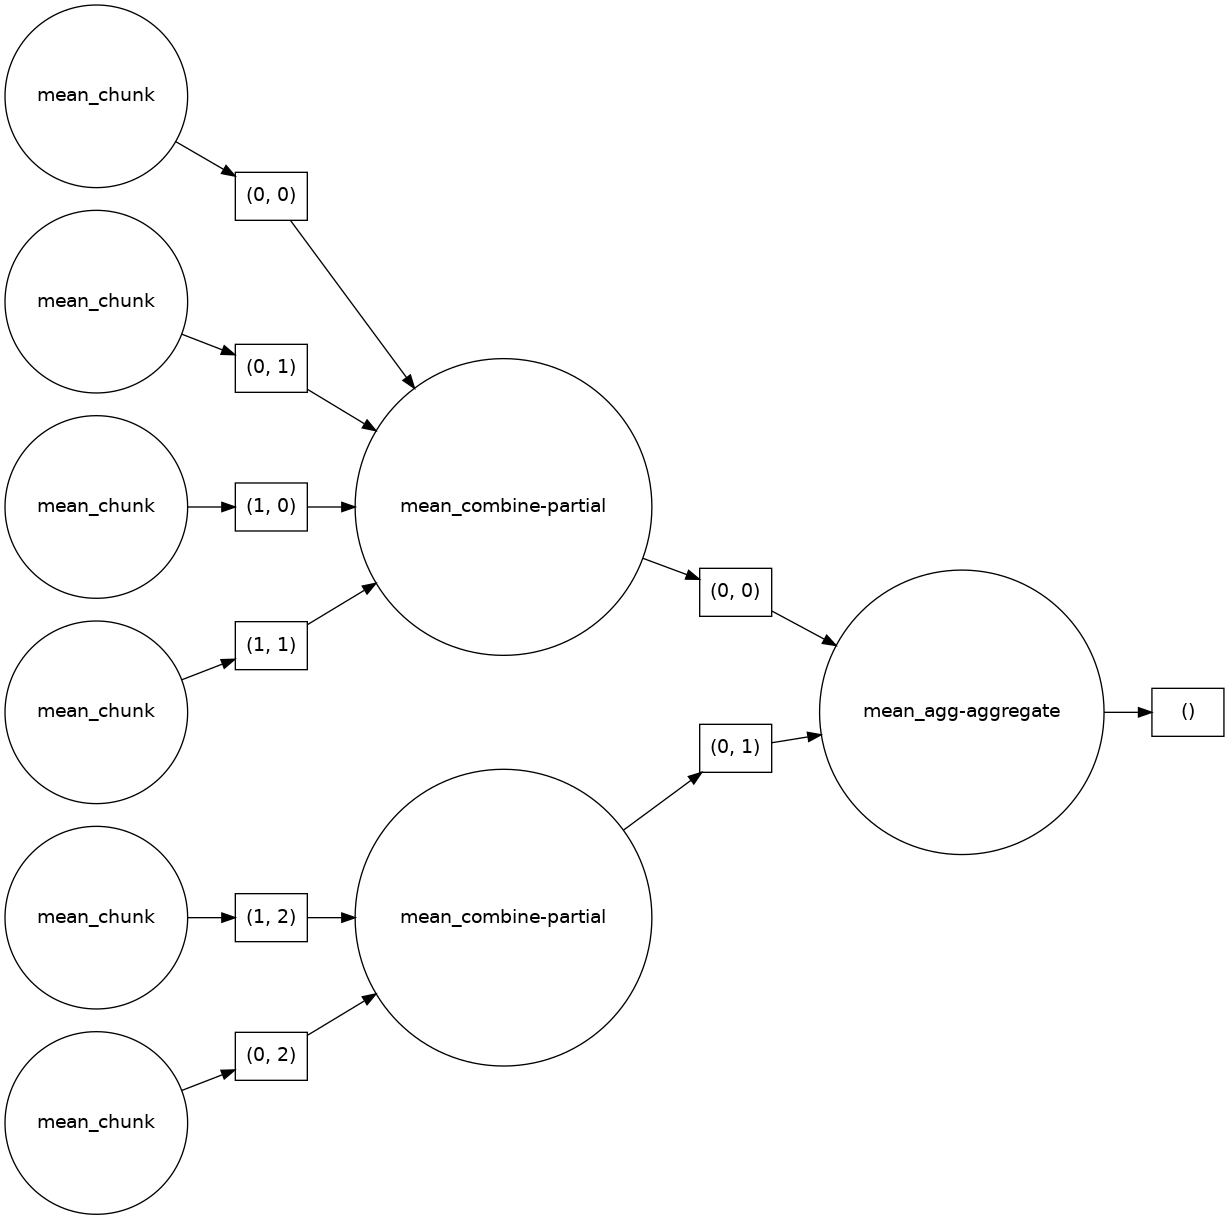

In [38]:
mean_of_ones_da = ones_da.mean()
mean_of_ones_da.visualize(rankdir="LR",optimize_graph=True)

## Larger Data
The previous example illustrated how Dask works, but using Dask is not really necessary (nor advisable) for an array of size 915.53 MiB. Let's try an example using bigger data and bigger calculations.

In [39]:
big_shape = (4000, 200, 4000)

# -- this will make a big numpy array that might not fit on your machine
#big_np = np.ones(big_shape)

Make a similar Dask Array with similar shape but specifying the `chunks` size:

In [40]:
big_chunk = (500, 100, 1000)
big_da = da.ones(big_shape,chunks=big_chunk)
big_da

dask.array<ones_like, shape=(4000, 200, 4000), dtype=float64, chunksize=(500, 100, 1000), chunktype=numpy.ndarray>

In [41]:
# size of data
#print("Memory size of NumPy dataset :  {:.2f} GiB".format(big_np.nbytes / 1024/1024/1024))
print("Memory size of Dask dataset  :  {:.2f} GiB".format(big_da.nbytes / 1024/1024/1024))

Memory size of Dask dataset  :  23.84 GiB


This may be close to the available memory/RAM that you have in your computer.

<div class="alert alert-block alert-warning">

<b>WARNING:</b> Do not try to `.visualize()` this array!

</div>

Let's try bigger calculations on this array:

In [42]:
#%%time 
#z_np = (big_np + big_np.T)[::2,:].mean()

In [43]:
%%time
# perform big computation
from dask.diagnostics import ProgressBar

z_da = (big_da + big_da.T)[::2,:].mean(axis=2)

result = z_da.compute()


CPU times: user 12.4 s, sys: 17.8 s, total: 30.2 s
Wall time: 8.28 s


All the usual NumPy functions work on dask arrays, though the computations will remain lazy until you either call `.compute()`, `.load()` or your want to plot the data.

As we discussed above, the way that Dask arrays are chunked can significantly affect the performance.

<div class="alert alert-block alert-warning">

<b>WARNING:</b> The way that arrays are chunked can significantly affect total performance. Poor chunking can singifincantly worsen performance of Dask compared to NumPy. 
</div>

In the remainder of this notebook, let's do a similar calculation using a different `chunks` size. 

We will learn more about best practices regarding `chunk` size later during the tutorial. 


## Supplementary Material: Rechunking Arrays

We can change the chunking of a Dask array, using the `rechunk` method. Please note that rechunking Dask arrays can be very expensive, so choosing an appropriate chunk size initially is ideal.

In [21]:
new_chunk_shape = (200,200,200)
rechunked_big_da = big_da.rechunk(new_chunk_shape)
rechunked_big_da

,Array,Chunk
Bytes,23.84 GiB,61.04 MiB
Shape,"(4000, 200, 4000)","(200, 200, 200)"
Count,1424 Tasks,400 Chunks
Type,float64,numpy.ndarray


In [22]:
%%time
# perform big computation on chunked array

z_da_rechunked = (rechunked_big_da + rechunked_big_da.T)[::2,:].mean(axis=2)

result = z_da_rechunked.compute()

CPU times: user 3.61 s, sys: 273 ms, total: 3.89 s
Wall time: 16.1 s


We can see how the choice of smaller chunks (more total chunks) **significantly** reduce the total performance of our computation. 

<div class="alert alert-block alert-info" markdown="1">

<b>TIP:</b> As a rule of thumb, a chunk should be big enough so that the computation on that chunk take significantly longer than the overhead from Dask scheduler. The Dask scheduler takes roughly 1ms per task for scheduling. 

</div>

Let's try a bigger chunk size:

In [23]:
new_chunk_shape = (1000,200,2000)
rechunked_big_da = big_da.rechunk(new_chunk_shape)
rechunked_big_da

dask.array<rechunk-merge, shape=(4000, 200, 4000), dtype=float64, chunksize=(1000, 200, 2000), chunktype=numpy.ndarray>

In [24]:
%%time
# perform big computation on chunked array

z_da_rechunked = (rechunked_big_da + rechunked_big_da.T)[::2,:].mean(axis=2)

result = z_da_rechunked.compute()

CPU times: user 1.88 s, sys: 262 ms, total: 2.14 s
Wall time: 30.6 s


Here we have chunk sizes that are ~3GB each. If our array was bigger, we had even loading the array on our memory.

<div class="alert alert-block alert-info" markdown="1">

<b>TIP:</b> As a rule of thumb, a chunk should be small enough to fit comfortably in the memory. Chunk sizes between 10MB-1GB are common, depending on your machine,

</div>


In [25]:
client.close()

## Resources and references

* Reference
    *  [Dask Docs](https://dask.org/)
    *  [Dask Examples](https://examples.dask.org/)
    *  [Dask Code](https://github.com/dask/dask/)
    *  [Dask Blog](https://blog.dask.org/)
    
    
    
*  Ask for help
    *   [`dask`](http://stackoverflow.com/questions/tagged/dask) tag on Stack Overflow, for usage questions
    *   [github discussions: dask](https://github.com/dask/dask/discussions) for general, non-bug, discussion, and usage questions
    *   [github issues: dask](https://github.com/dask/dask/issues/new) for bug reports and feature requests
    

* Pieces of this notebook are adapted from the following sources
  * https://tutorial.dask.org/02_array.html#Performance-comparison
  * https://earth-env-data-science.github.io/lectures/dask/dask_arrays.html
  * https://github.com/andersy005/xarray-tutorial/blob/master/notebooks/09-dask-array.ipynb
